# Модуль: Unsupervised Learning

<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 12 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

# Методы кластеризации
<h3> Plan </h3>

* **Напоминание лекции** 
 - Задача кластеризации
 - Демо k-means, DBSCAN
 - Реализация k-means
  
* **Кластеризация текстов**
 - Описание данных
 - Агломеративная кластеризация
 - k-means
 
* **AUTOENCODER**
 - кластеризация MNIST с помощью AUTOENCODER


** Key words: **
    * задача кластеризации, 
    * статистические методы, алгоритм kMeans
    * агломеративная кластеризация, дивизональная кластеризация, формула Ланса-Уильямса
    * алгоритм DBSCAN

In [1]:
import os
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score

import pylab

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


from IPython.display import Image, SVG

%matplotlib inline

<h1 align="center"> Напоминание лекции </h1>
** Вопросы **
* В чем суть задачи кластеризации?
* Как типы алгоритмов кластеризации вы знаете?
* Какие основные шаги выделяют в алгоритме k-means?
* Приведите пример данных, для которых k-means не сможет выдать правильный ответ.
* Опишите кратко суть алгоритма DBSCAN и приведите пример структуры данных, для которых предназначен алгоритм DBSCAN

## k-means demo
<a href='https://www.naftaliharris.com/blog/visualizing-k-means-clustering/'> k-means </a>

## DBSCAN demo
<a href='https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/'> DBSCAN </a>


---------
<h1 align="center"> Реализация k-means </h1>

** k-means steps: **
 - 1. обновить кластеры (принадлежность объектов к кластерам):
     ## $$ y_i := \arg\min\limits_{y\in Y} \rho (x_i ; \mu_y),~~i = 1,\dots,\ell;$$
 - 2: обновить веса кластеров
##    $$ \mu_{yj} := \frac{\sum_{i=1}^\ell [y_i = y]\cdot f_j(x_i)} {\sum_{i=1}^\ell[y_i = y]}$$

поясните обозначения $\mu_y, f_j(x_i)$, 


In [85]:
class KMeans():
    def __init__(self, K, X=None, N=0):
        '''
        K - number of clusters
        X - dataset (if X is None then X is generated from gauss distribution)
        N - a number of samples to generate if X is None
        '''
        self.K = K
        if X == None:
            if N == 0:
                raise Exception("If no data is provided, \
                                 a parameter N (number of points) is needed")
            else:
                self.N = N
                self.X = self._init_board_gauss(N, K)
        else:
            self.X = X
            self.N = len(X)
            
        # initialization            
        self.mu = None # a list of centers of clusters
        self.clusters = None # labels of samples
        self.method = None # method for sampling initial centers of clusters
 
    def _init_board_gauss(self, N, k):
        '''
        N - a number of samples to generate
        k - a number of clusters
        '''
        n = float(N)/k
        X = []
        for i in range(k):
            c = (random.uniform(-1,1), random.uniform(-1,1))
            s = random.uniform(0.05,0.15)
            x = []
            while len(x) < n:
                a,b = np.array([np.random.normal(c[0],s),np.random.normal(c[1],s)])
                # Continue drawing points from the distribution in the range [-1,1]
                if abs(a) and abs(b)<1:
                    x.append([a,b])
            X.extend(x)
        X = np.array(X)[:N]
        return X
 
    def plot_board(self, fig_size=(10,7) ):
        '''
        '''
        X = self.X
        fig = plt.figure(figsize = fig_size)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        if self.mu and self.clusters:
            mu = self.mu
            clus = self.clusters
#             print(clus)
            K = self.K
            for m, clu in clus.items():
                cs = plt.cm.spectral(1.*m/self.K)
                plt.plot(mu[m][0], mu[m][1], 'o', marker='*', \
                         markersize=20, color=cs)
#                 print(zip(clus[m]))
                plt.plot([x[0] for x in clus[m]], [x[1] for x in clus[m]], '.', \
                         markersize=8, color=cs, alpha=0.5)
        else:
            plt.plot(X[:,0], X[:,1], '.', alpha=0.5)
        if self.method == '++':
            tit = 'K-means++'
        else:
            tit = 'K-means with random initialization'
        pars = 'N=%s, K=%s' % (str(self.N), str(self.K))
        plt.title('\n'.join([pars, tit]), fontsize=16)
        plt.savefig('kpp_N%s_K%s.png' % (str(self.N), str(self.K)), \
                    bbox_inches='tight', dpi=200)
 
    def _cluster_points(self):
        '''
        expectation step in Kmeans 
        '''
        mu = self.mu
        clusters  = {}
        for x in self.X:
            bestmukey = !!!обновите привязку объектов к центрам кластеров (используйте np.linalg.norm )!!!
            try:
                clusters[bestmukey].append(!!!обновите центры кластеров!!!)
            except KeyError:
                clusters[bestmukey] = [x]
        self.clusters = clusters
 
    def _reevaluate_centers(self):
        '''
        Maximization step in Kmeans
        '''
        clusters = self.clusters
        newmu = []
        keys = sorted(self.clusters.keys())
        for k in keys:
            newmu.append(np.mean(clusters[k], axis = 0))
        self.mu = newmu
 
    def _has_converged(self):
        '''
        condition of convergence of cluster points
        '''
        K = len(self.oldmu)
        return(!!!рассчитайте условие того, что множество центров кластеров не изменилось!!!  and len(set([tuple(a) for a in self.mu])) == K)
 
    def find_centers(self, method='random'):
        self.method = method
        X = self.X
        K = self.K
#         print(X)
#         self.oldmu = random.sample(list(X), K)
        if method != '++':
            # Initialize to K random centers
            self.mu = random.sample(list(X), K)
        while not self._has_converged():
            self.oldmu = self.mu # remember previous cluster centers
            # Assign all points in X to clusters
            self.!!!обновите разметку кластеров!!!
            # Reevaluate centers
            self.!!!обновите центры кластеров!!!

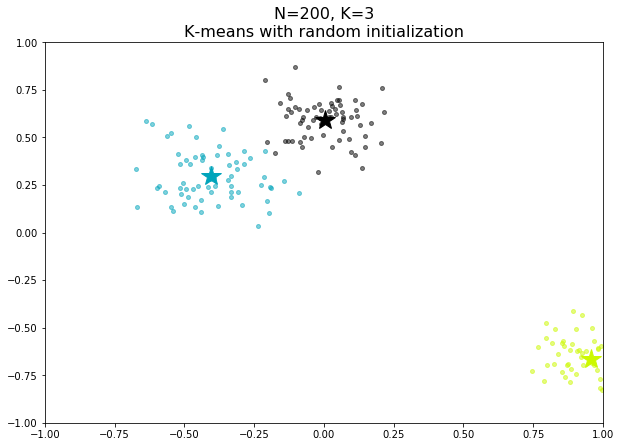

In [86]:
kmeans = KMeans(K=3, N=200)
kmeans.find_centers()
kmeans.plot_board(fig_size=(10,7))

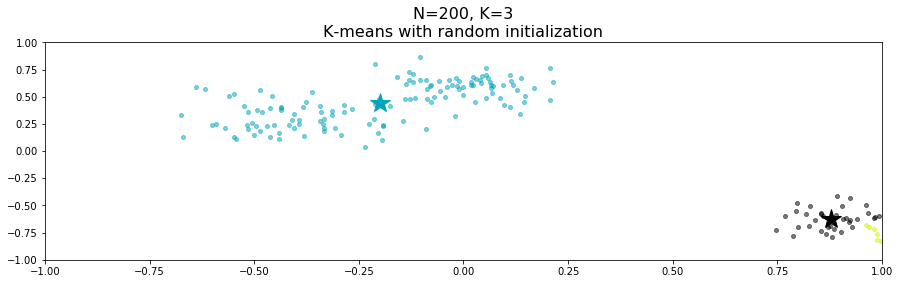

In [92]:
kmeans.find_centers()
kmeans.plot_board(fig_size=(15,4))

### Improve to Kmeans++

In [134]:
class KPlusPlus(KMeans):
    def _dist_from_centers(self):
        cent = self.mu
        X = self.X
        D2 = np.array([min([np.linalg.norm(x-c)**2 for c in cent]) for x in X])
        self.D2 = D2
 
    def _choose_next_center(self):
        self.probs = self.D2/self.D2.sum()
        self.cumprobs = self.probs.cumsum()
        r = (random.random()+1.0)/2
        ind = np.where(self.cumprobs >= r)[0][0]
        return(self.X[ind])
 
    def init_centers(self):
        self.mu = random.sample(list(self.X), 1)
        while len(self.mu) < self.K:
            self._dist_from_centers()
            self.mu.append(self._choose_next_center())
 
    def plot_init_centers(self, fig_size = (10,7)):
        X = self.X
        fig = plt.figure(figsize=(10,5))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.plot(X[:,0], X[:,1], '.', alpha=0.5)
        plt.plot([x[0] for x in self.mu], [x[1] for x in self.mu], 'ro')
        plt.savefig('kpp_init_N%s_K%s.png' % (str(self.N),str(self.K)), \
                    bbox_inches='tight', dpi=200)

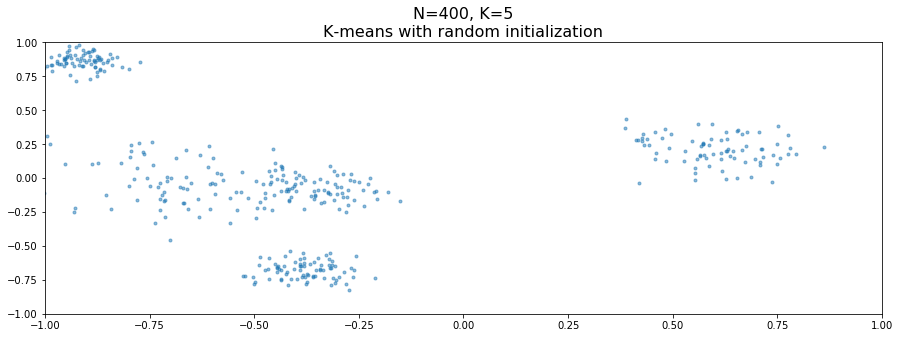

In [135]:
kplusplus = KPlusPlus(K=5, N=400)
kplusplus.plot_board(fig_size = (15,5))

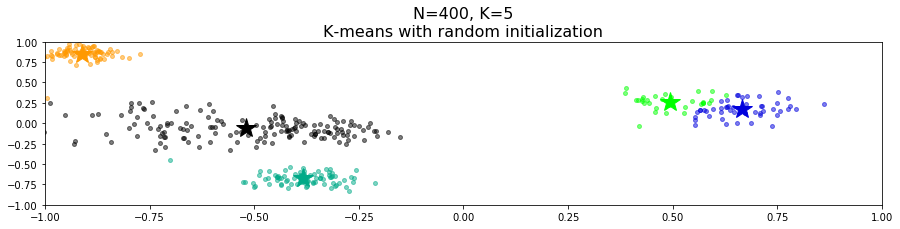

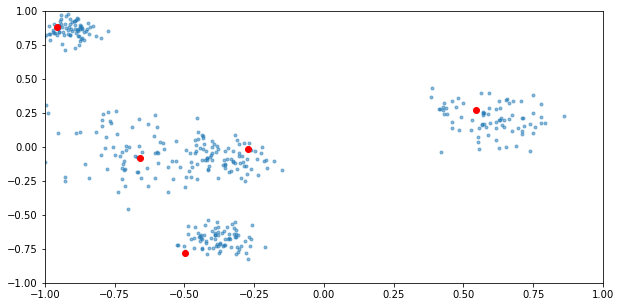

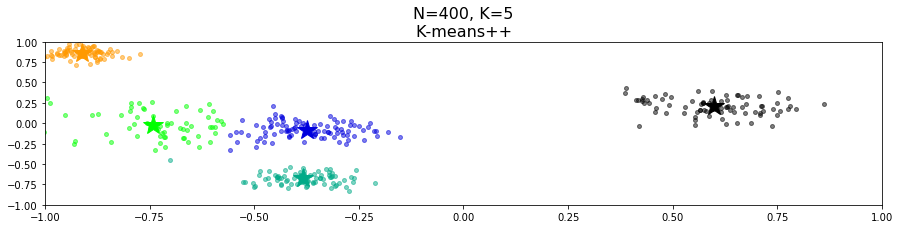

In [136]:
# Random initialization
kplusplus.find_centers(method='random')
kplusplus.plot_board(fig_size = (15,3))
# k-means++ initialization
kplusplus.init_centers()
kplusplus.plot_init_centers(fig_size=(10,3))
kplusplus.find_centers(method='++')
kplusplus.plot_board(fig_size = (15,3))

-------
<h1 align="center">Кластеризация текстов</h1> 


##### Пример by V. Kantor
--------
** Вопросы:**
- Зачем нужна кластеризации текстов? 
- Что является объектами (samples), что такое признаки для этих объектов?

## Выборка

In [137]:
from sklearn.datasets import fetch_20newsgroups

In [138]:
train_all = fetch_20newsgroups(subset='train')
print (train_all.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [139]:
simple_dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

In [140]:
print (simple_dataset.data[0])

From: erik@cheshire.oxy.edu (Erik Adams)
Subject: HELP!!  My Macintosh "luggable" has lines on its screen!
Organization: Occidental College, Los Angeles, CA 90041 USA.
Distribution: comp
Lines: 20

Okay, I don't use it very much, but I would like for it to keep working
correctly, at least as long as Apple continues to make System software
that will run on it, if slowly :-)

Here is the problem:  When the screen is tilted too far back, vertical
lines appear on the screen.  They are every 10 pixels or so, and seem
to be affected somewhat by opening windows and pulling down menus.
It looks to a semi-technical person like there is a loose connection
between the screen and the rest of the computer.

I am open to suggestions that do not involve buying a new computer,
or taking this one to the shop.  I would also like to not have
to buy one of Larry Pina's books.  I like Larry, but I'm not sure
I feel strongly enough about the computer to buy a service manual
for it.

On a related note:  what

In [141]:
print (simple_dataset.data[-1])

From: dlecoint@garnet.acns.fsu.edu (Darius_Lecointe)
Subject: Re: Sabbath Admissions 5of5
Organization: Florida State University
Lines: 21

I find it interesting that cls never answered any of the questions posed. 
Then he goes on the make statements which make me shudder.  He has
established a two-tiered God.  One set of rules for the Jews (his people)
and another set for the saved Gentiles (his people).  Why would God
discriminate?  Does the Jew who accepts Jesus now have to live under the
Gentile rules.

God has one set of rules for all his people.  Paul was never against the
law.  In fact he says repeatedly that faith establishes rather that annuls
the law.  Paul's point is germane to both Jews and Greeks.  The Law can
never be used as an instrument of salvation.  And please do not combine
the ceremonial and moral laws in one.

In Matt 5:14-19 Christ plainly says what He came to do and you say He was
only saying that for the Jews's benefit.  Your Christ must be a
politician, speaki

In [142]:
print (simple_dataset.data[-2])

From: scialdone@nssdca.gsfc.nasa.gov (John Scialdone)
Subject: CUT Vukota and Pilon!!!
News-Software: VAX/VMS VNEWS 1.41    
Organization: NASA - Goddard Space Flight Center
Lines: 32

I have been to all 3 Isles/Caps tilts at the Crap Centre this year, all Isles
wins and there is no justification for Vukota and Pilon to play for the Isles.
Vukota is absolutely the worst puck handler in the world!! He couldn't hit a
bull in the ass with a banjo!! Al must remember a few years back when Mick 
scored 3 goals in one period against the Caps in a 5-3 Isles win. I was there
and was astonished as was the rest of the crowd. Wake-up Al!!! Years later he's
gotten worse. He's a cheap shot artist and always ends up getting
stupid/senseless penalties. I think he would make a good police officier!!!

As for Pilon, he can't carry the puck out to center ice by himself. He either
makes a bad pass resulting in a turnover, or he attempts to bring the puck 
towards the neutral zone and skates right into an 

In [143]:
print (len(simple_dataset.data))

1777


### Признаки

In [145]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = vectorizer.fit_transform(simple_dataset.data)
matrix.shape

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(1777, 3767)

## Аггломеративная кластеризация (neighbour joining)

In [146]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
preds = model.fit_predict(matrix.toarray())

In [147]:
print(list(preds))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [148]:
print(matrix[0])

  (0, 1246)	0.3906389385132699
  (0, 239)	0.09501028877632492
  (0, 1659)	0.07226670936760915
  (0, 2082)	0.09656717763921
  (0, 1846)	0.06741426312477893
  (0, 2991)	0.3895610830528872
  (0, 810)	0.0809427637021726
  (0, 2056)	0.09616720743610424
  (0, 319)	0.10054935380579341
  (0, 625)	0.05207173909126517
  (0, 3553)	0.07346689959490565
  (0, 1121)	0.06442816229222373
  (0, 838)	0.10154477899829951
  (0, 69)	0.06858267052730141
  (0, 2413)	0.10258878033617379
  (0, 3555)	0.06229087987706688
  (0, 3600)	0.05737015279917228
  (0, 2273)	0.057960021837659234
  (0, 1905)	0.08173536478989506
  (0, 3722)	0.09501028877632492
  (0, 926)	0.11742059318548873
  (0, 1991)	0.0711302768586001
  (0, 2048)	0.07488448956033757
  (0, 354)	0.06947437383545055
  (0, 900)	0.12357635170024021
  :	:
  (0, 2868)	0.08596208970791505
  (0, 855)	0.20162554088271673
  (0, 301)	0.055632566960467825
  (0, 2422)	0.09427236106959615
  (0, 3285)	0.11264581593118286
  (0, 1831)	0.1250526461821779
  (0, 620)	0.1118065

In [149]:
vectorizer.get_feature_names()

['00',
 '000',
 '01',
 '02',
 '03',
 '030',
 '0358',
 '04',
 '040',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '100',
 '1000',
 '101',
 '102',
 '104',
 '105',
 '106',
 '109',
 '11',
 '110',
 '112',
 '113',
 '119',
 '12',
 '120',
 '126',
 '127',
 '128',
 '129',
 '13',
 '132',
 '133',
 '14',
 '140',
 '15',
 '150',
 '152',
 '16',
 '160',
 '17',
 '170',
 '175',
 '18',
 '180',
 '19',
 '1987',
 '1988',
 '1989',
 '199',
 '1990',
 '1991',
 '1992',
 '1993',
 '1993apr14',
 '1993apr15',
 '1993apr16',
 '1993apr18',
 '1993apr19',
 '1993apr20',
 '1993apr5',
 '1993apr6',
 '1d17',
 '1d20',
 '1st',
 '20',
 '200',
 '2000',
 '203',
 '21',
 '210',
 '22',
 '23',
 '230',
 '24',
 '240',
 '241',
 '25',
 '253',
 '256',
 '25mhz',
 '26',
 '27',
 '28',
 '286',
 '29',
 '2nd',
 '30',
 '300',
 '30602',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '386',
 '39',
 '3rd',
 '40',
 '400',
 '403',
 '408',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '486',
 '49',
 '4mb',
 '4th',
 '50',
 '500',
 '51'

In [150]:
vectorizer.get_feature_names()[877]

'connect'

In [151]:
simple_dataset.data[0]

'From: erik@cheshire.oxy.edu (Erik Adams)\nSubject: HELP!!  My Macintosh "luggable" has lines on its screen!\nOrganization: Occidental College, Los Angeles, CA 90041 USA.\nDistribution: comp\nLines: 20\n\nOkay, I don\'t use it very much, but I would like for it to keep working\ncorrectly, at least as long as Apple continues to make System software\nthat will run on it, if slowly :-)\n\nHere is the problem:  When the screen is tilted too far back, vertical\nlines appear on the screen.  They are every 10 pixels or so, and seem\nto be affected somewhat by opening windows and pulling down menus.\nIt looks to a semi-technical person like there is a loose connection\nbetween the screen and the rest of the computer.\n\nI am open to suggestions that do not involve buying a new computer,\nor taking this one to the shop.  I would also like to not have\nto buy one of Larry Pina\'s books.  I like Larry, but I\'m not sure\nI feel strongly enough about the computer to buy a service manual\nfor it.\n

In [152]:
simple_dataset.target

array([0, 0, 1, ..., 0, 1, 2], dtype=int64)

In [153]:
preds

array([0, 0, 0, ..., 0, 2, 1], dtype=int64)

In [154]:
# Assessement
mapping = {2 : 1, 1: 2, 0: 0}
mapped_preds = [mapping[pred] for pred in preds]
# print (float(sum(mapped_preds != simple_dataset.target)) / len(simple_dataset.target))
print(acc(mapped_preds, simple_dataset.target))

0.3590320765334834


In [155]:
import itertools
def validate_with_mappings(preds, target):
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
#         print (float(sum(mapped_preds != target)) / len(target))
        print(acc(mapped_preds, target))
validate_with_mappings(preds, simple_dataset.target)

0.325267304445695
0.3275182892515476
0.34721440630275746
0.3590320765334834
0.3157006190208216
0.325267304445695


## KMeans

In [156]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print (preds)
print (simple_dataset.target)
validate_with_mappings(preds, simple_dataset.target)

[0 0 2 ... 0 2 1]
[0 0 1 ... 0 1 2]
0.029262802476083285
0.32639279684862127
0.34946539110861
0.9527293190770962
0.018007878446820485
0.3241418120427687


In [157]:
# Compare with Linear Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
print (cross_val_score(clf, matrix, simple_dataset.target).mean())

0.9853603185880773


** Вопрос: ** очень высокая точность кластеризации текстов, очень близкая к точности Supervised алгоритма. Почему?

## Более сложная выборка

In [158]:
noteasy_dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'comp.os.ms-windows.misc', 'comp.graphics'])
matrix = vectorizer.fit_transform(noteasy_dataset.data)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [159]:
model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print (preds)
print (noteasy_dataset.target)
validate_with_mappings(preds, noteasy_dataset.target)

[0 1 2 ... 0 2 0]
[2 1 1 ... 2 0 2]
0.753565316600114
0.2966343411294923
0.39361095265259555
0.1289218482601255
0.11751283513976041
0.3097547062179121


In [160]:
clf = LogisticRegression()
print (cross_val_score(clf, matrix, noteasy_dataset.target).mean())

0.917279226713189


## SVD + KMeans

In [161]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
validate_with_mappings(preds, noteasy_dataset.target)

0.4067313177410154
0.0889903023388477
0.793496862521392
0.29720479178551057
0.29606389047347403
0.11751283513976041


In [162]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=321)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
validate_with_mappings(preds, noteasy_dataset.target)

0.286936679977182
0.15459212778094694
0.11066742726754136
0.2994865944095836
0.41357672561323444
0.7347404449515117


** Вопрос: ** всё равно сумели добиться довольно высокой точности. В чем причина?

# Меры качества кластеризации
--------
** Вопросы:**
- Как измерить качество кластеризации? 
- Как измерить качество кластеризации нерзмеченной выборки?

### Homogeneity:  each cluster contains only members of a single class

### Completeness: all members of a given class are assigned to the same cluster

### V-measure:
### $$v = 2 \cdot \frac{(homogeneity \cdot completeness)}{ (homogeneity + completeness)}$$

In [ ]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score,v_measure_score 

print(completeness_score(noteasy_dataset.target, preds))
print(homogeneity_score(noteasy_dataset.target, preds))
print(v_measure_score(noteasy_dataset.target, preds))

### Вывод

1. Получили интерпретируемый результат на обеих выборках
2. На простых выбрках kMeans и Agglomerative работают хорошо в рамках начального приближения.

<h1 align="center">Автоенкодеры</h1>  
<img src='https://blog.keras.io/img/ae/autoencoder_schema.jpg'>
##### by aymericdamien/TensorFlow-Examples
----
** Вопросы:**
 * Что такое автоенкодер?
 * В каких задачах применяются автоенкодеры?

In [164]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [165]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [166]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

In [167]:
# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [168]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

Step 1: Minibatch Loss: 0.443665
Step 1000: Minibatch Loss: 0.135382
Step 2000: Minibatch Loss: 0.120402
Step 3000: Minibatch Loss: 0.114046
Step 4000: Minibatch Loss: 0.104823
Step 5000: Minibatch Loss: 0.104348
Step 6000: Minibatch Loss: 0.100066
Step 7000: Minibatch Loss: 0.092281
Step 8000: Minibatch Loss: 0.091842
Step 9000: Minibatch Loss: 0.089045
Step 10000: Minibatch Loss: 0.085709
Step 11000: Minibatch Loss: 0.082238
Step 12000: Minibatch Loss: 0.082439
Step 13000: Minibatch Loss: 0.080481
Step 14000: Minibatch Loss: 0.081689
Step 15000: Minibatch Loss: 0.077133
Step 16000: Minibatch Loss: 0.076724
Step 17000: Minibatch Loss: 0.075644
Step 18000: Minibatch Loss: 0.073868
Step 19000: Minibatch Loss: 0.070807
Step 20000: Minibatch Loss: 0.071334
Step 21000: Minibatch Loss: 0.067351
Step 22000: Minibatch Loss: 0.063819
Step 23000: Minibatch Loss: 0.064031
Step 24000: Minibatch Loss: 0.060919
Step 25000: Minibatch Loss: 0.057984
Step 26000: Minibatch Loss: 0.058178
Step 27000: Mi

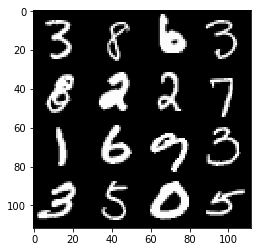

Reconstructed Images


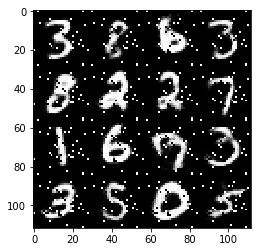

In [169]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

<h1 align="center">Conclusion</h1>  

## <a href="https://github.com/ml-mipt/ml-mipt-part1/tree/master/2018/hw/hw9"> HW9 </a>
  
** Reference **
- ESL https://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf
- К.В. Воронцов, Математические методы обучения по прецедентам, http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf
- http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/


** Обратная связь ** 
  ** <span style="font-size: 11pt"> <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> отзыв </a> о семинаре </span> **
  
  ** <span style="font-size: 11pt"> <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> отзыв </a> о лекции </span> **